In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional

plt.rcParams.update({
    'font.size': 14,
    'axes.linewidth': 1.2,
    'axes.labelsize': 18,
    'axes.titlesize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'grid.alpha': 0.3,
    'grid.linewidth': 0.8,
    'lines.linewidth': 1.5,
    'patch.linewidth': 0.8
})

In [26]:
def plot_partition_comparison(df: pd.DataFrame, 
                            partition_column: str = 'partitions',
                            strategy_column: str = 'strategy',
                            output_path: Optional[str] = None,
                            figsize: tuple = (12, 8)):
    """
    Create grouped bar plot showing strategies for each partition count.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with parallel execution analysis results
    partition_column : str
        Name of column containing partition counts
    strategy_column : str
        Name of column containing strategy names
    output_path : str, optional
        Path to save the plot
    figsize : tuple
        Figure size (width, height) in inches
    """
    
    # Get unique partitions and strategies
    partitions = sorted(df[partition_column].unique())
    strategies = df[strategy_column].unique()
    n_partitions = len(partitions)
    n_strategies = len(strategies)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set up bar positions
    bar_width = 0.25  # Width of each bar
    x = np.arange(n_partitions)  # Positions for partition groups
    
    # Consistent component colors
    colors = {
        'computation': '#FF6347',      # Tomato
        'overlap': '#FFD700',          # Gold  
        'packet': '#6495ED',           # Cornflower Blue
        'idle': "#C0C0C0"              # Silver
    }
    
    max_height = 0  # Track maximum bar height for label positioning
    
    # Plot bars for each strategy
    for i, strategy in enumerate(strategies):
        strategy_data = df[df[strategy_column] == strategy]
        
        # Extract data for this strategy across partitions
        comp_data = []
        packet_data = []
        overlap_data = []
        idle_data = []
        total_data = []
        
        for partition in partitions:
            partition_row = strategy_data[strategy_data[partition_column] == partition]
            if not partition_row.empty:
                row = partition_row.iloc[0]
                comp_cycles = row['computation_occupied_cycles']
                packet_cycles = row['packet_occupied_cycles'] 
                overlap_cycles = row['overlap_cycles']
                idle_cycles = row['idle_cycles']
                total_cycles = row['total_simulation_cycles']
                
                # Three-part breakdown
                pure_comp = comp_cycles - overlap_cycles
                pure_packet = packet_cycles - overlap_cycles
                
                comp_data.append(pure_comp)
                overlap_data.append(overlap_cycles)
                packet_data.append(pure_packet)
                idle_data.append(idle_cycles)
                total_data.append(total_cycles)
            else:
                # No data for this partition/strategy combination
                comp_data.append(0)
                overlap_data.append(0)
                packet_data.append(0)
                idle_data.append(0)
                total_data.append(0)
        
        # Calculate bar positions for this strategy
        bar_positions = x + (i - n_strategies/2 + 0.5) * bar_width
        
        # Create stacked bars for this strategy
        p1 = ax.bar(bar_positions, comp_data, bar_width,
                    label='Computation' if i == 0 else "",
                    color=colors['computation'], alpha=0.85,
                    edgecolor='white', linewidth=0.8)
        
        p2 = ax.bar(bar_positions, overlap_data, bar_width,
                    bottom=comp_data,
                    label='Comp + Data Flow' if i == 0 else "",
                    color=colors['overlap'], alpha=0.85,
                    edgecolor='white', linewidth=0.8)
        
        p3 = ax.bar(bar_positions, packet_data, bar_width,
                    bottom=np.array(comp_data) + np.array(overlap_data),
                    label='Data Flow' if i == 0 else "",
                    color=colors['packet'], alpha=0.85,
                    edgecolor='white', linewidth=0.8)
        
        #p4 = ax.bar(bar_positions, idle_data, bar_width,
        #            bottom=np.array(comp_data) + np.array(overlap_data) + np.array(packet_data),
        #            label='Idle' if i == 0 else "",
        #            color=colors['idle'], alpha=0.85,
        #            edgecolor='white', linewidth=0.8)
        
        # Track maximum height for label positioning
        bar_heights = np.array(comp_data) + np.array(overlap_data) + np.array(packet_data) + np.array(idle_data)
        max_height = max(max_height, np.max(bar_heights))
        
        # Add strategy labels at the top of each bar (45 degree rotation)
        for j, partition in enumerate(partitions):
            bar_height = bar_heights[j]
            ax.text(bar_positions[j], bar_height + max_height * 0.02, 
                    strategy.title(),
                    ha='center', va='bottom', fontweight='bold',
                    rotation=45, fontsize=12)
                    #bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # Customize axes
    ax.set_xlabel('Number of Partitions', fontweight='bold')
    #ax.set_ylabel('Cycles (×10$^{6}$)', fontweight='bold')
    ax.set_ylabel('Cycles', fontweight='bold')
    
    # Format y-axis to show millions
    #ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}'))
    
    # Set x-axis
    ax.set_xticks(x)
    ax.set_xticklabels(partitions)
    
    # Adjust y-axis limit to accommodate labels
    ax.set_ylim(0, max_height * 1.15)
    
    # Legend
    ax.legend(loc='best', frameon=True, fancybox=True, shadow=True)
    
    # Grid
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # Show all spines but without ticks on top/right
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.tick_params(top=False, right=False)
    ax.tick_params(left=True, bottom=True, direction='in')
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight', 
                    facecolor='white', edgecolor='none')
        print(f"Publication-quality plot saved to: {output_path}")
    
    plt.show()
    
    # Print detailed comparison table grouped by partition
    print("\n" + "="*100)
    print("PARALLEL EXECUTION ANALYSIS - BY PARTITION COUNT")
    print("="*100)
    
    for partition in partitions:
        print(f"\n=== {partition} Partitions ===" )
        print(f"{'Strategy':<12} {'Total (M)':<10} {'Comp %':<8} {'Comm %':<8} {'Overlap %':<10} {'Speedup':<9} {'Util %':<8}")
        print("-" * 80)
        
        partition_data = df[df[partition_column] == partition]
        for _, row in partition_data.iterrows():
            strategy = row[strategy_column]
            total_M = row['total_simulation_cycles'] / 1e6
            comp_pct = row['computation_percentage']
            comm_pct = row['packet_percentage']
            overlap_pct = row['overlap_percentage']
            speedup = row['parallelism_speedup']
            util = row['computation_utilization']
            
            print(f"{strategy:<12} {total_M:<10.1f} {comp_pct:<7.1f}% {comm_pct:<7.1f}% {overlap_pct:<9.1f}% {speedup:<8.2f}x {util:<7.1f}%")


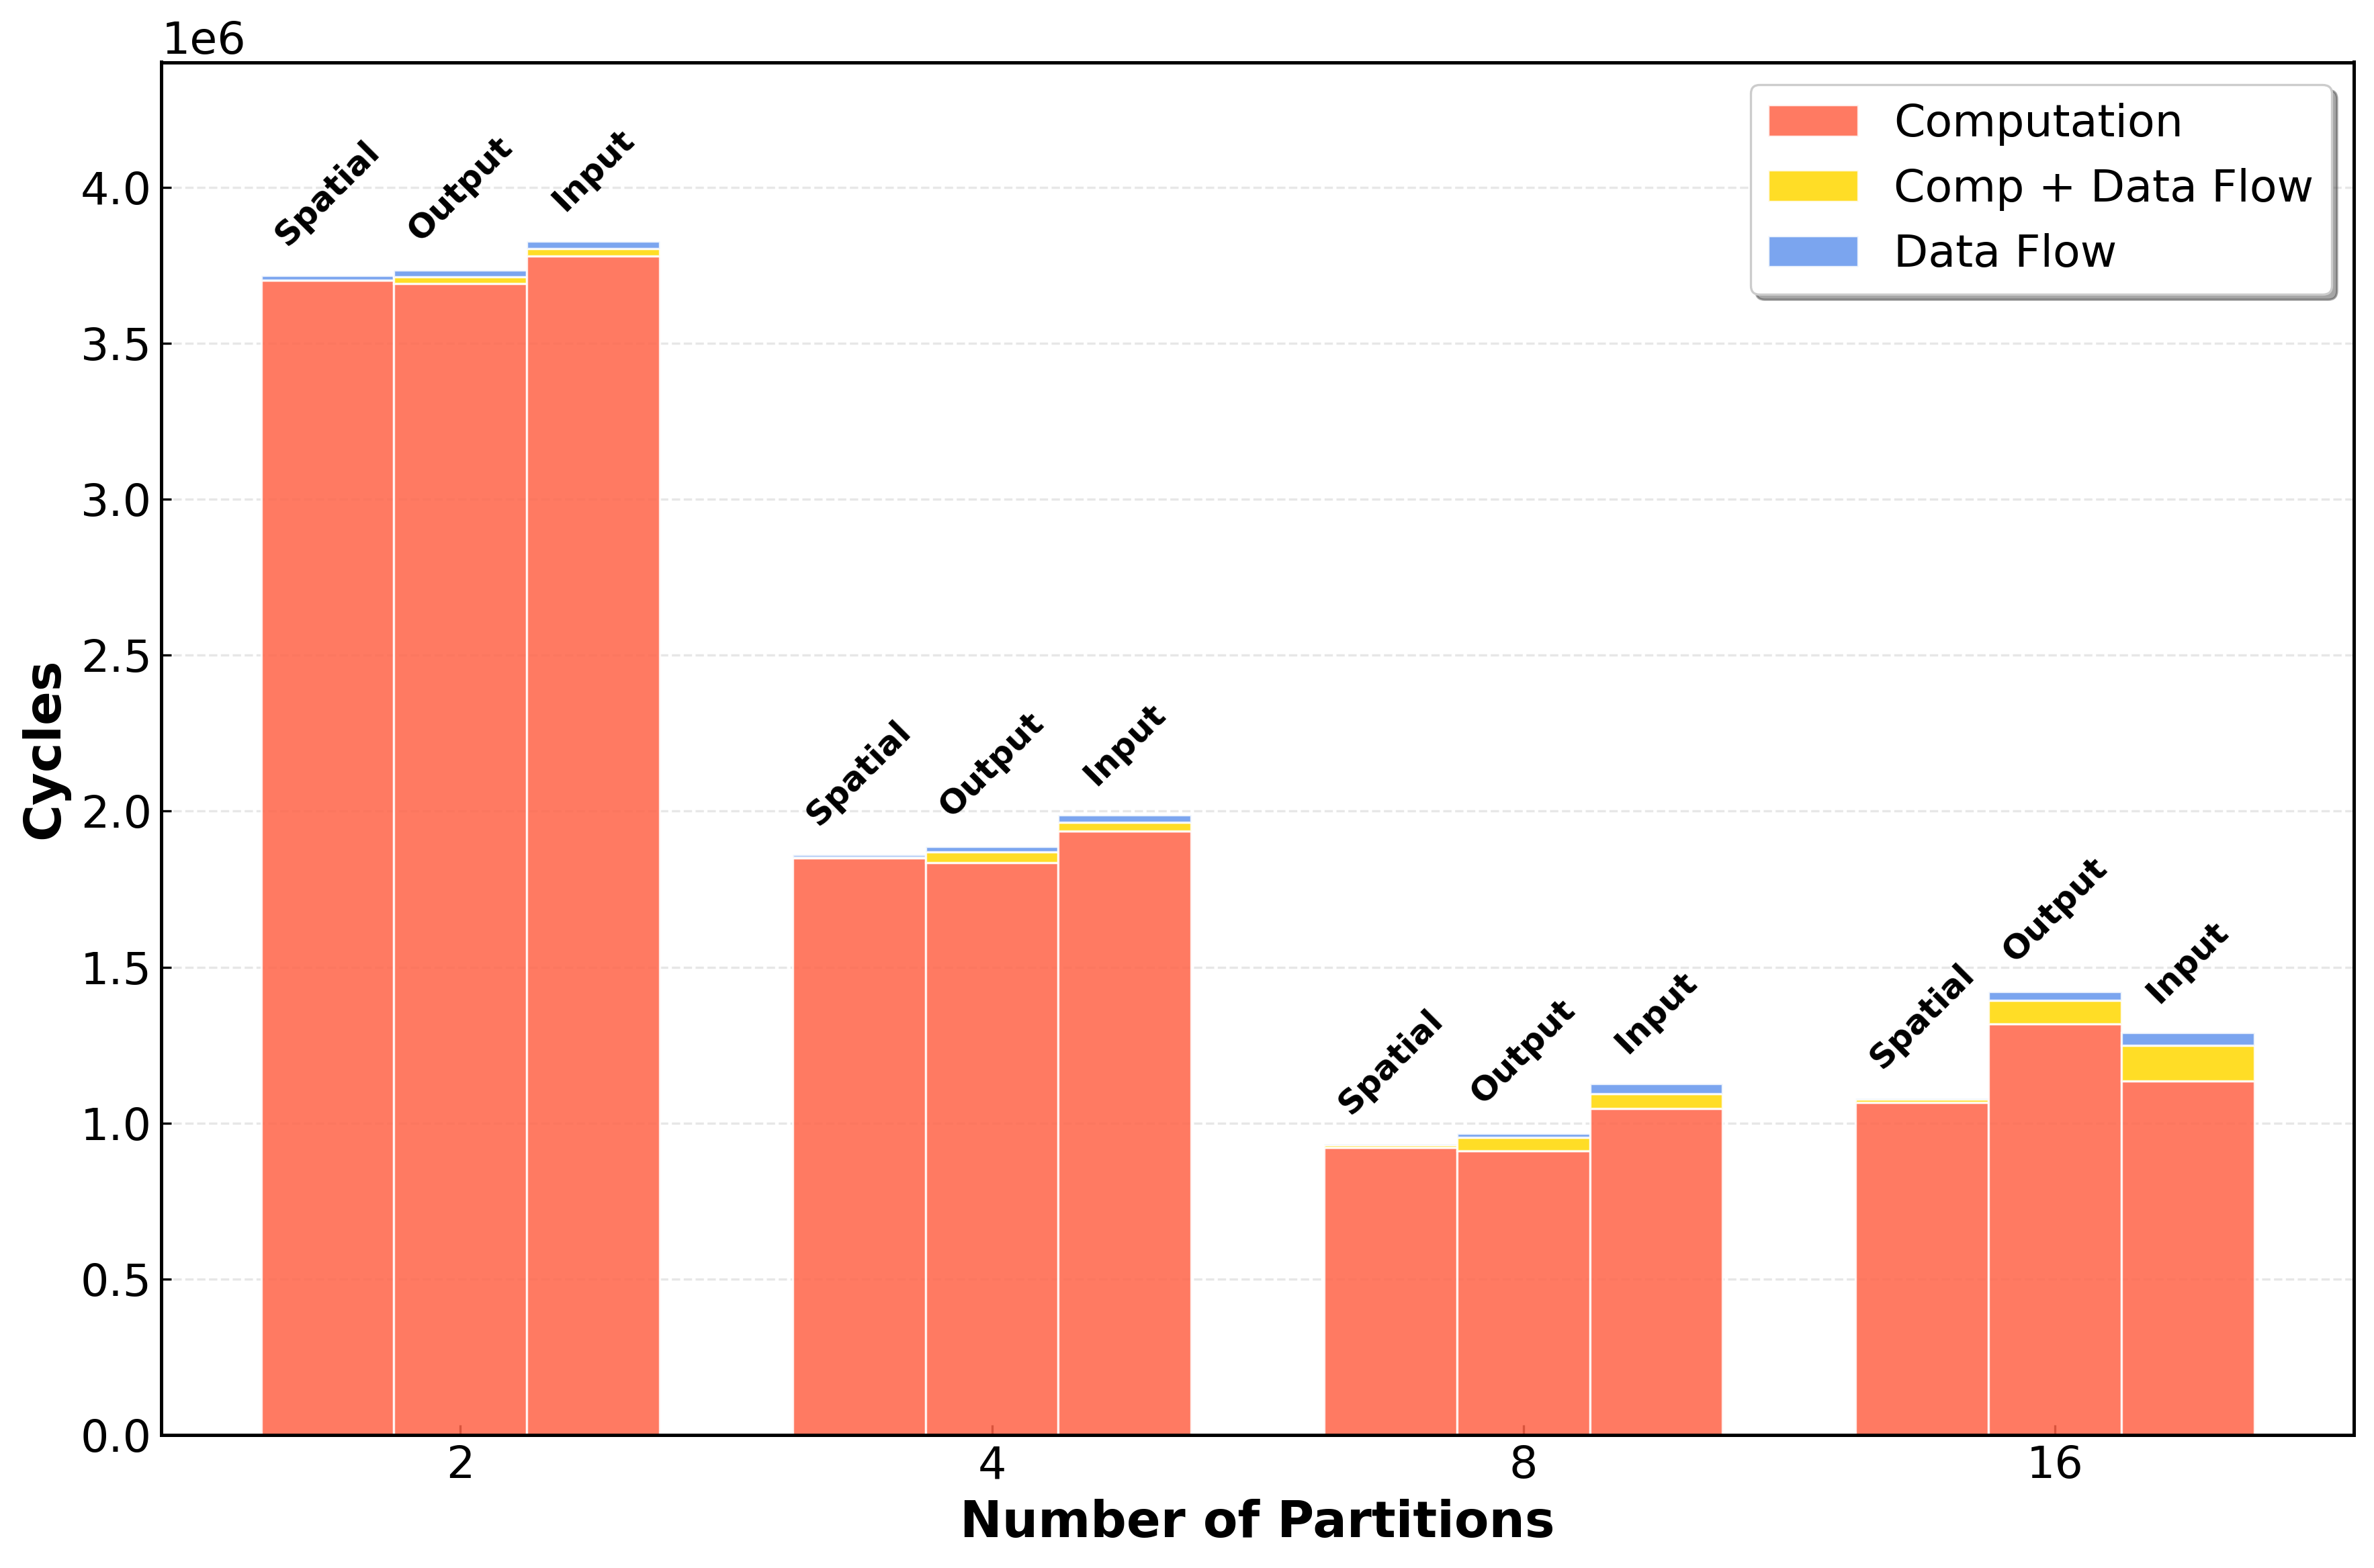


PARALLEL EXECUTION ANALYSIS - BY PARTITION COUNT

=== 2 Partitions ===
Strategy     Total (M)  Comp %   Comm %   Overlap %  Speedup   Util %  
--------------------------------------------------------------------------------
spatial      3.7        99.6   % 0.4    % 0.0      % 2.00    x 100.0  %
output       3.7        99.5   % 1.2    % 0.6      % 1.99    x 99.7   %
input        3.8        99.4   % 1.2    % 0.6      % 1.97    x 98.7   %

=== 4 Partitions ===
Strategy     Total (M)  Comp %   Comm %   Overlap %  Speedup   Util %  
--------------------------------------------------------------------------------
spatial      1.9        99.5   % 0.5    % 0.1      % 4.00    x 100.0  %
output       1.9        99.1   % 2.7    % 1.8      % 3.96    x 99.0   %
input        2.0        98.8   % 2.6    % 1.4      % 3.93    x 98.3   %

=== 8 Partitions ===
Strategy     Total (M)  Comp %   Comm %   Overlap %  Speedup   Util %  
--------------------------------------------------------------------------

In [27]:
# Load your data
df = pd.read_csv('../data/18Sept_data/model_resnet_test_3x3_torus_all_strategies_comparison.csv')

# Create the new partition comparison plot
plot_partition_comparison(df)

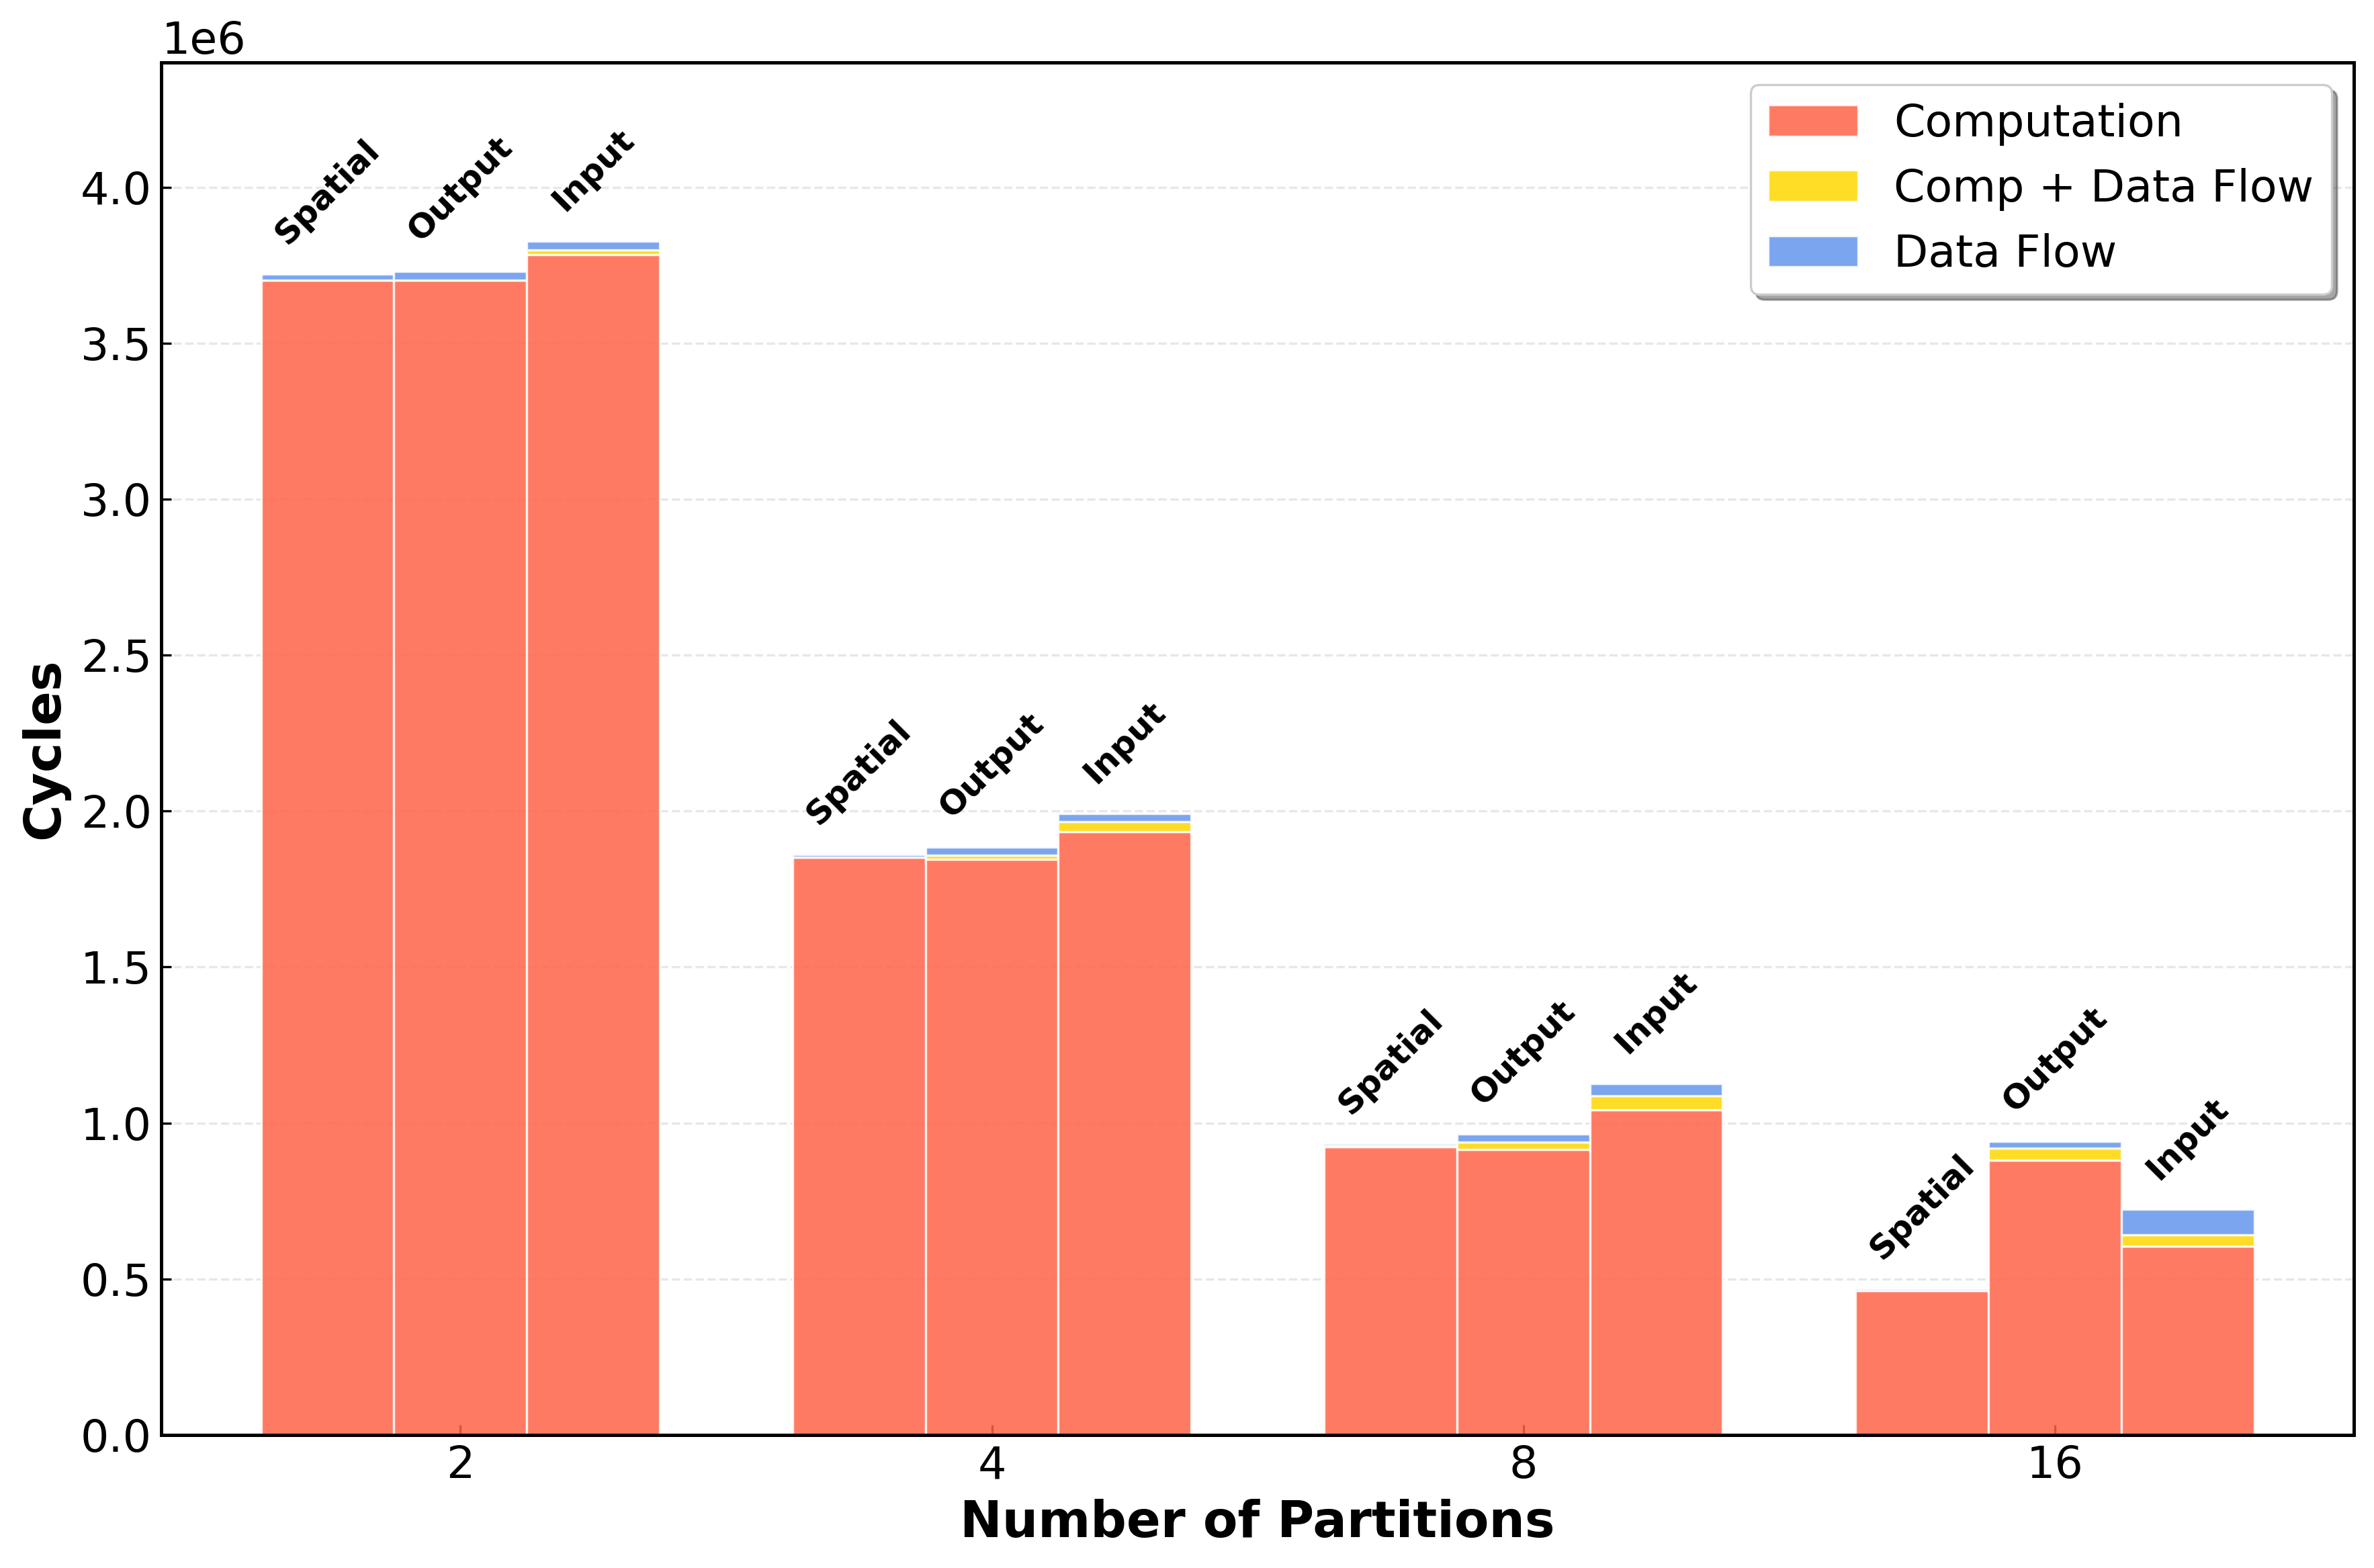


PARALLEL EXECUTION ANALYSIS - BY PARTITION COUNT

=== 2 Partitions ===
Strategy     Total (M)  Comp %   Comm %   Overlap %  Speedup   Util %  
--------------------------------------------------------------------------------
spatial      3.7        99.5   % 0.5    % 0.0      % 2.00    x 100.0  %
output       3.7        99.2   % 0.8    % 0.0      % 2.00    x 100.0  %
input        3.8        99.3   % 1.1    % 0.4      % 1.98    x 98.9   %

=== 4 Partitions ===
Strategy     Total (M)  Comp %   Comm %   Overlap %  Speedup   Util %  
--------------------------------------------------------------------------------
spatial      1.9        99.5   % 0.5    % 0.0      % 4.00    x 100.0  %
output       1.9        98.6   % 2.1    % 0.7      % 3.99    x 99.6   %
input        2.0        98.7   % 3.0    % 1.7      % 3.93    x 98.2   %

=== 8 Partitions ===
Strategy     Total (M)  Comp %   Comm %   Overlap %  Speedup   Util %  
--------------------------------------------------------------------------

In [28]:
# Load your data
df = pd.read_csv('../data/18Sept_data/model_resnet_test_4x4_torus_all_strategies_comparison.csv')

# Create the new partition comparison plot
plot_partition_comparison(df)


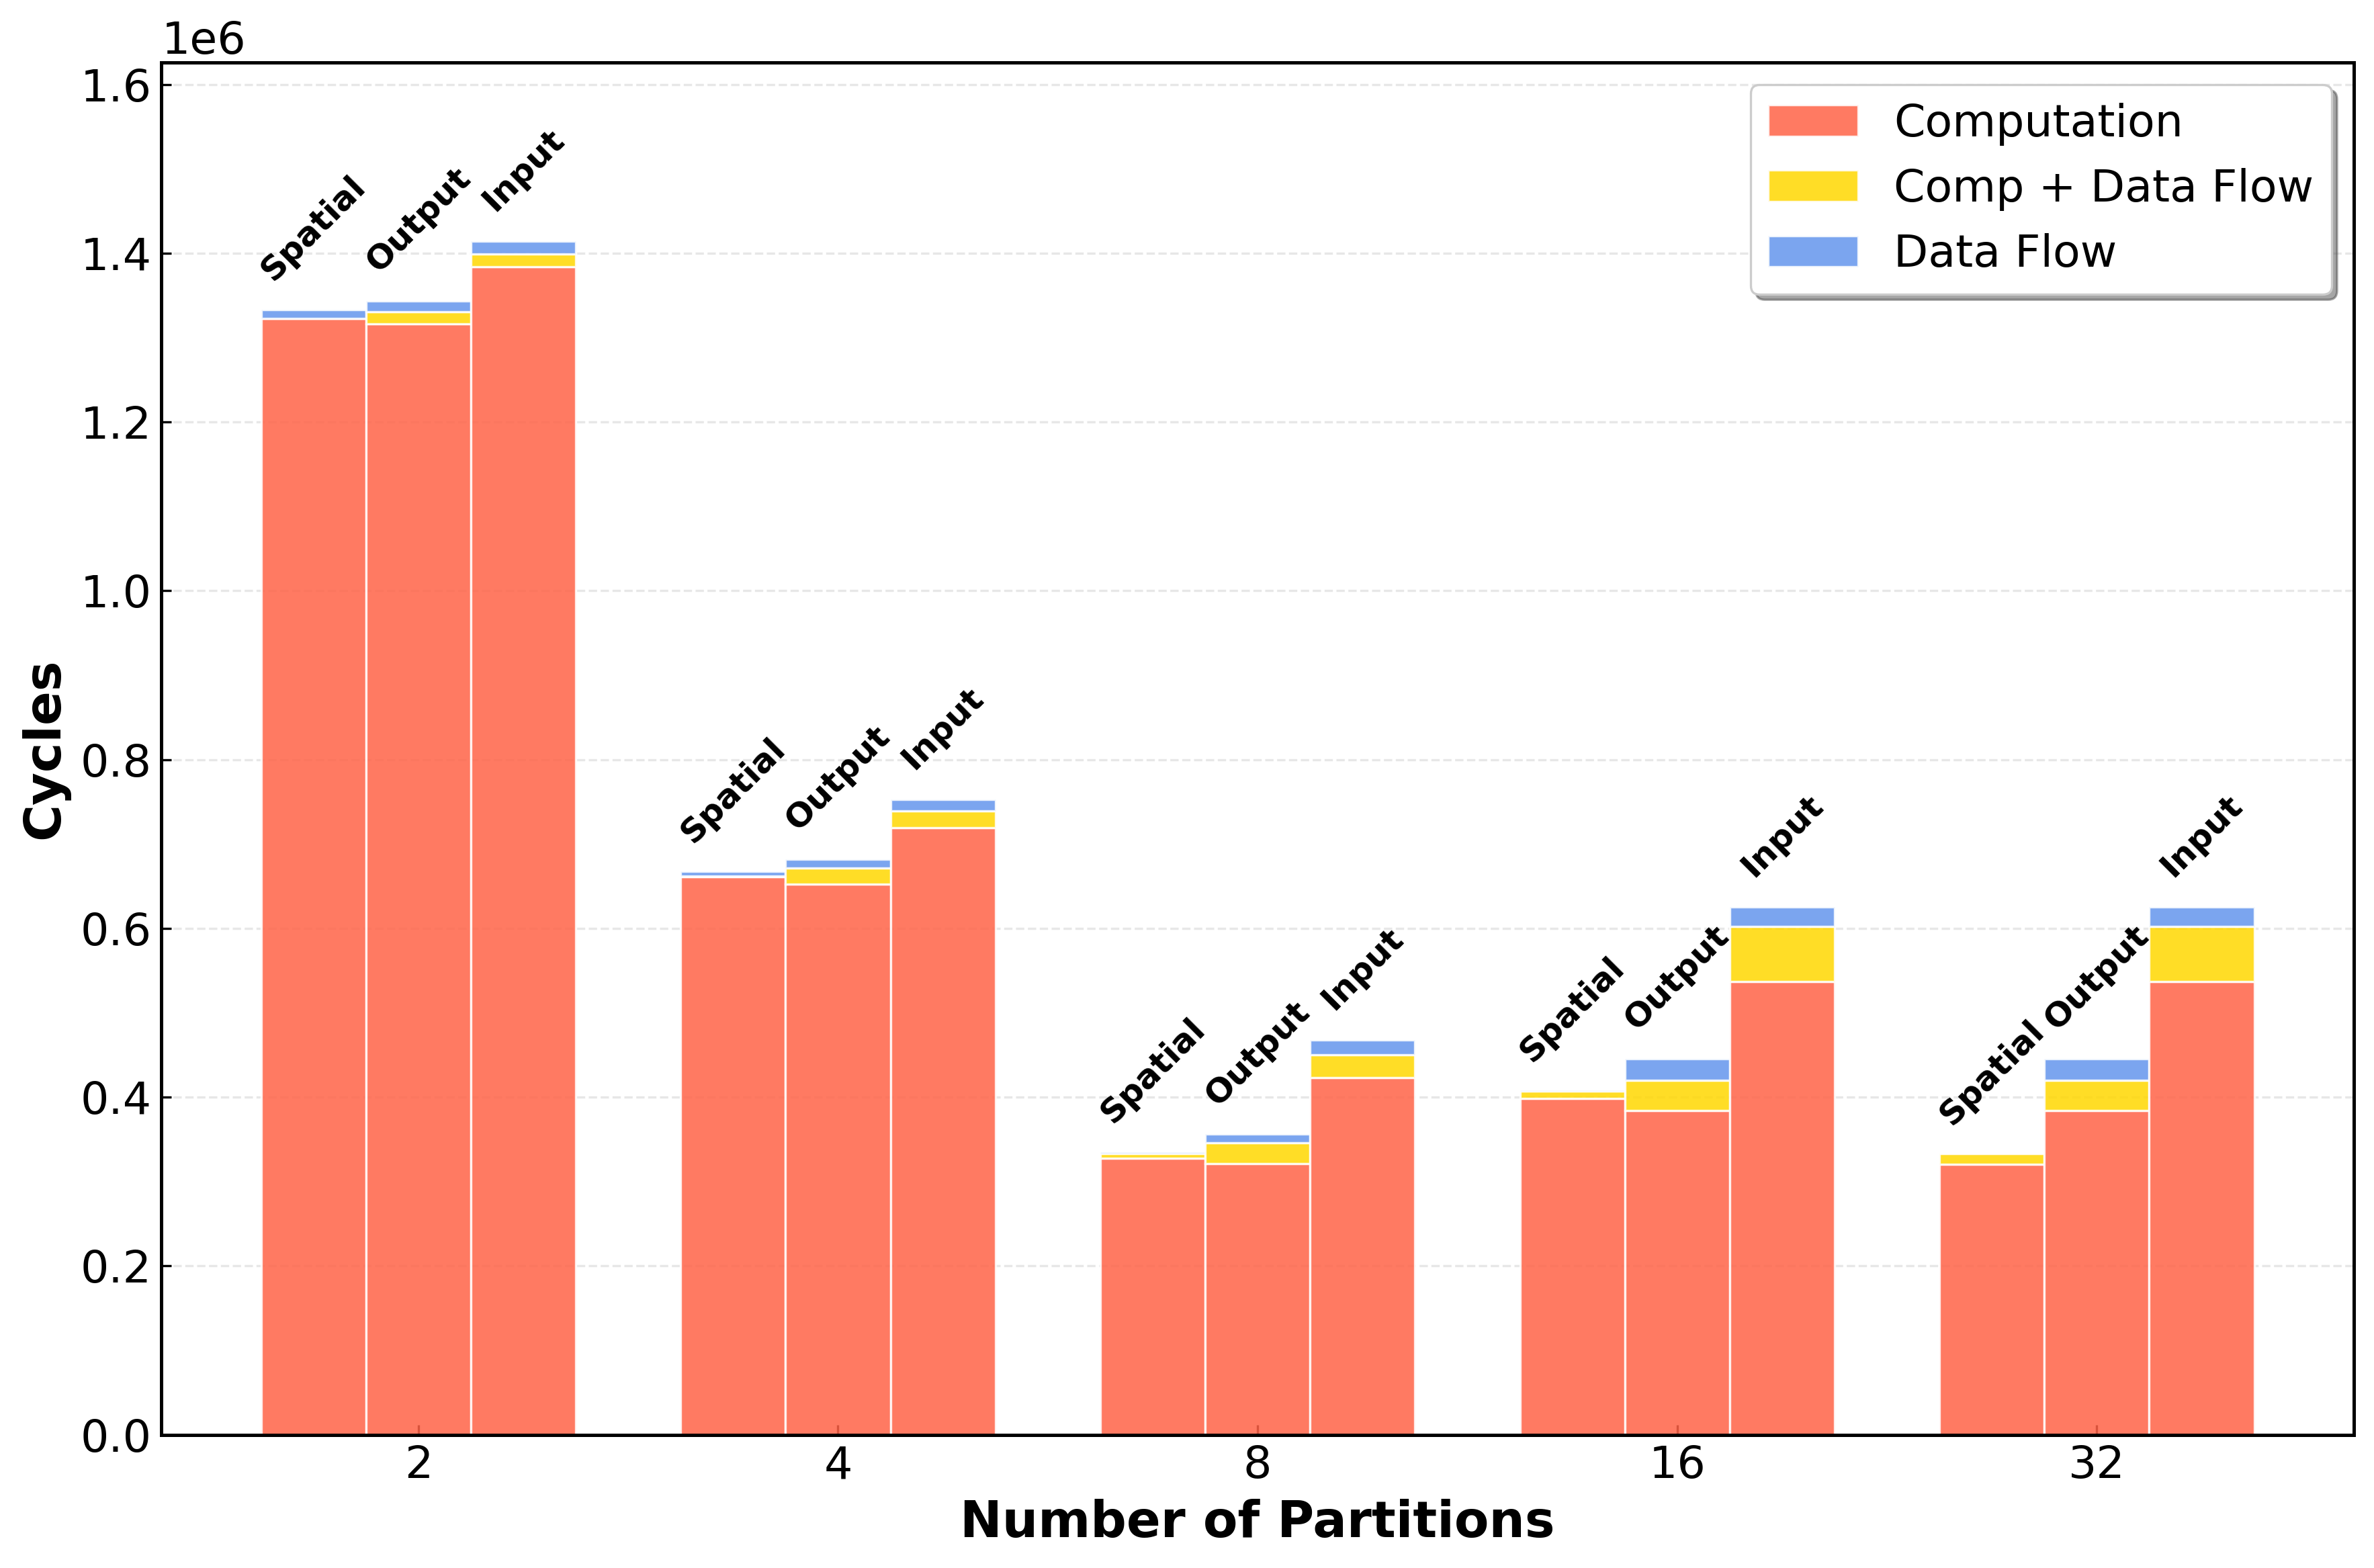


PARALLEL EXECUTION ANALYSIS - BY PARTITION COUNT

=== 2 Partitions ===
Strategy     Total (M)  Comp %   Comm %   Overlap %  Speedup   Util %  
--------------------------------------------------------------------------------
spatial      1.3        99.2   % 0.7    % 0.0      % 2.00    x 100.0  %
output       1.3        99.0   % 2.1    % 1.1      % 1.99    x 99.4   %
input        1.4        98.9   % 2.1    % 1.1      % 1.94    x 96.9   %

=== 4 Partitions ===
Strategy     Total (M)  Comp %   Comm %   Overlap %  Speedup   Util %  
--------------------------------------------------------------------------------
spatial      0.7        99.2   % 0.9    % 0.1      % 4.00    x 99.9   %
output       0.7        98.4   % 4.3    % 2.7      % 3.94    x 98.5   %
input        0.8        98.2   % 4.5    % 2.7      % 3.84    x 96.0   %

=== 8 Partitions ===
Strategy     Total (M)  Comp %   Comm %   Overlap %  Speedup   Util %  
--------------------------------------------------------------------------

In [29]:
#EARLY BLOCKS RESNET32 3x3

# Load your data
df = pd.read_csv('../data/18Sept_data/model_resnet_early_blocks_3x3_torus_all_strategies_comparison.csv')

# Create the new partition comparison plot
plot_partition_comparison(df)

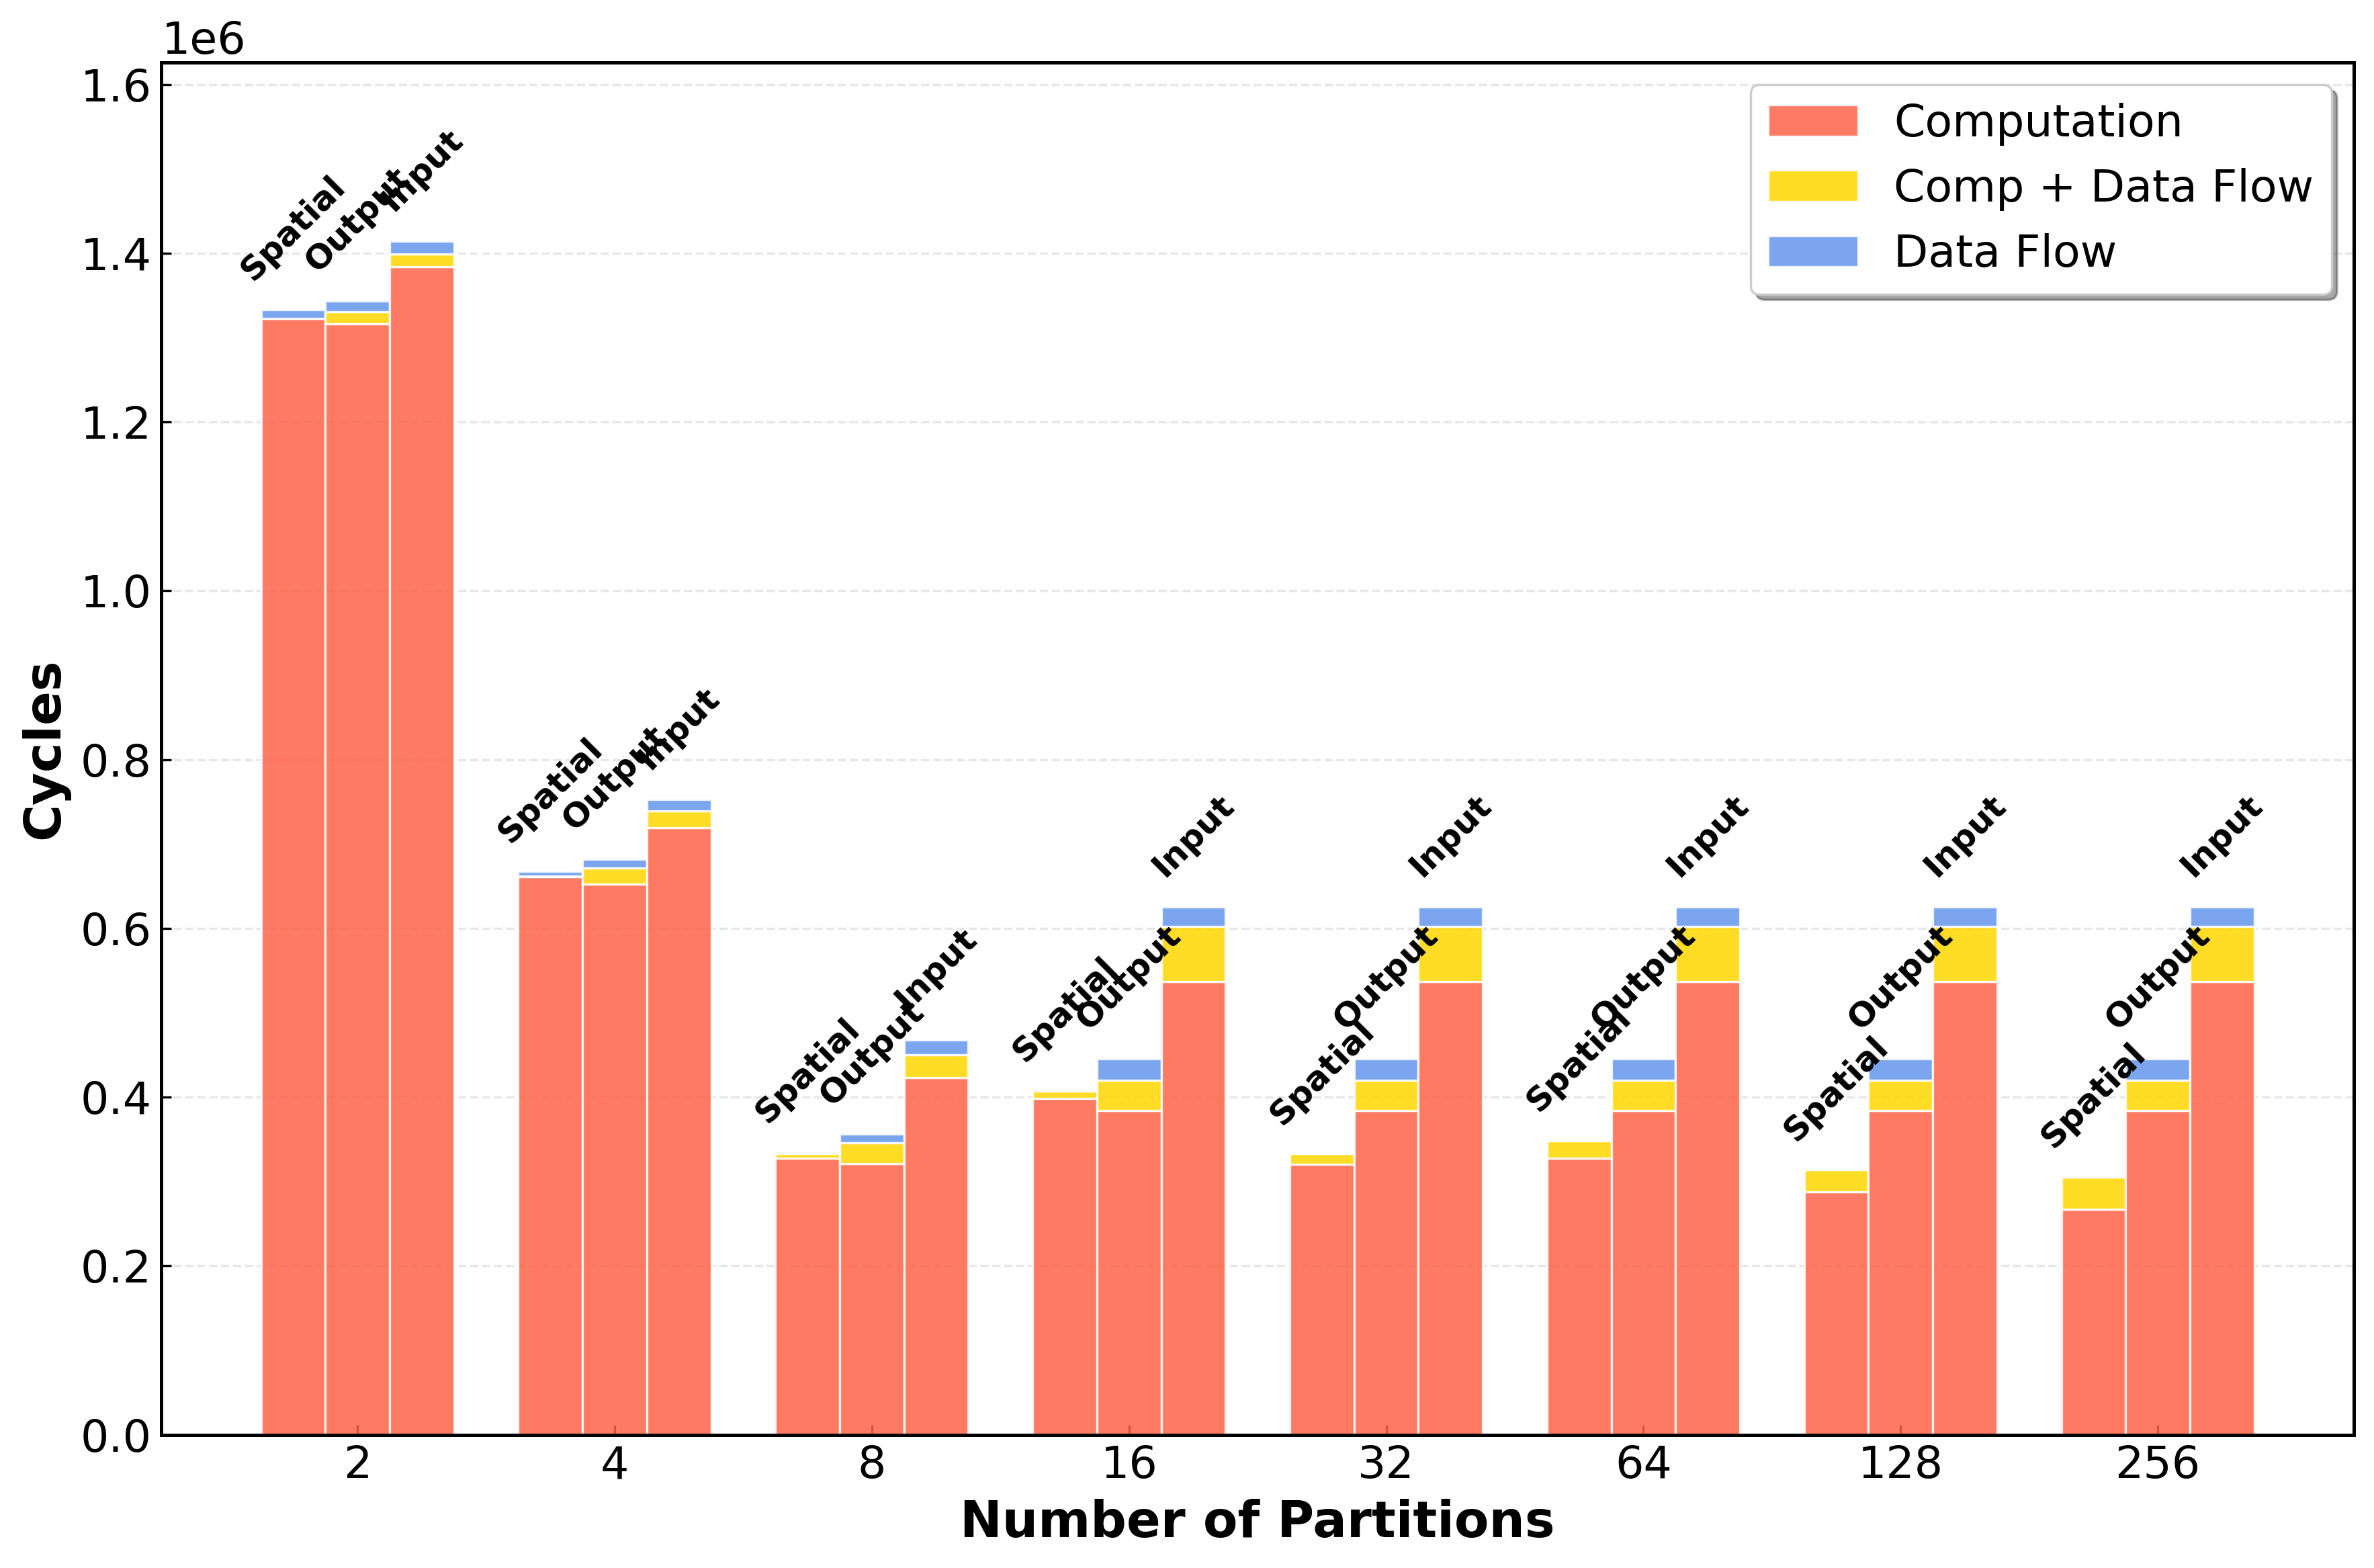


PARALLEL EXECUTION ANALYSIS - BY PARTITION COUNT

=== 2 Partitions ===
Strategy     Total (M)  Comp %   Comm %   Overlap %  Speedup   Util %  
--------------------------------------------------------------------------------
spatial      1.3        99.2   % 0.7    % 0.0      % 2.00    x 100.0  %
output       1.3        99.0   % 2.1    % 1.1      % 1.99    x 99.4   %
input        1.4        98.9   % 2.1    % 1.1      % 1.94    x 96.9   %

=== 4 Partitions ===
Strategy     Total (M)  Comp %   Comm %   Overlap %  Speedup   Util %  
--------------------------------------------------------------------------------
spatial      0.7        99.2   % 0.9    % 0.1      % 4.00    x 99.9   %
output       0.7        98.4   % 4.3    % 2.7      % 3.94    x 98.5   %
input        0.8        98.2   % 4.5    % 2.7      % 3.84    x 96.0   %

=== 8 Partitions ===
Strategy     Total (M)  Comp %   Comm %   Overlap %  Speedup   Util %  
--------------------------------------------------------------------------

In [30]:
#LATE BLOCKS RESNET32 3x3

# Load your data
df = pd.read_csv('../data/18Sept_data/model_resnet_early_blocks_2_3x3_torus_all_strategies_comparison.csv')

# Create the new partition comparison plot
plot_partition_comparison(df)

